### 不要跑。會當

In [1]:
import json
from datetime import datetime
import pandas as pd


def analyze_sales_growth_by_genre(genre_filter):
    """
    分析特定類型遊戲（例如 Action）的月度銷售增長，並將結果存為 CSV 檔。
    
    參數：
    genre_filter : str
        要篩選的遊戲類型標籤（例如 'Action'）。如果為 None 或空字串，則不篩選遊戲類別。
    """
    
    json_filenames = ['game_data_aaa.json', 'game_data_aa.json', 'game_data_indie.json']

    csv_filenames = ['sales_growth_3A', 'sales_growth_2A', 'sales_growth_indie']

    for json_file, csv_file in zip(json_filenames, csv_filenames):

        # 讀取 JSON 檔案
        with open(f"../../../data/rawdata/{json_file}", 'r') as file:
            data = json.load(file)

        result_list = []

        # 處理每一筆遊戲的數據
        for game in data:
            # 只篩選包含指定類型標籤的遊戲，除非沒有指定篩選條件
            if genre_filter and 'genres' in game and genre_filter not in game['genres']:
                continue
            
            steam_id = game['steamId']
            
            # 將 releaseDate 從毫秒轉換為日期格式
            release_date = datetime.utcfromtimestamp(game['releaseDate'] / 1000).date()
            
            # 將 history 中的 timeStamp 轉換為 datetime 並按月分組
            history = game['history']
            history_sorted = sorted(history, key=lambda x: datetime.strptime(x['timeStamp'], '%Y-%m-%d %H:%M:%S'))
            
            # 儲存每月的第一筆銷售數據
            sales_per_month = {}
            for record in history_sorted:
                timestamp = datetime.strptime(record['timeStamp'], '%Y-%m-%d %H:%M:%S')
                year_month = (timestamp.year, timestamp.month)
                
                # 如果該月份尚未存儲，將第一筆銷售記錄添加到字典
                if year_month not in sales_per_month:
                    sales_per_month[year_month] = {
                        'firstTimeStamp': record['timeStamp'],
                        'firstSales': record['sales']
                    }

            # 將結果添加到列表中，計算月增長量
            prev_sales = None  # 儲存上個月的第一筆 sales
            for year_month, sales_record in sorted(sales_per_month.items()):
                current_sales = sales_record['firstSales']
                
                # 計算本月與上個月之間的銷售增長
                if prev_sales is not None:
                    monthly_sales_growth = current_sales - prev_sales
                else:
                    monthly_sales_growth = current_sales  # 沒有上個月數據，增長量就是當月銷售量
                
                result_list.append({
                    'steamId': steam_id,
                    'releaseDate': release_date,
                    'year': year_month[0],
                    'month': year_month[1],
                    'firstTimeStamp': sales_record['firstTimeStamp'],
                    'firstSales': current_sales,
                    'monthlySalesGrowth': monthly_sales_growth
                })
                
                prev_sales = current_sales  # 更新上個月的 sales

        # 將結果轉換為 DataFrame
        result_df = pd.DataFrame(result_list)
        
        # 儲存為 CSV
        result_df.to_csv(f"../../../data/processed/{csv_file}_{genre_filter}.csv", index=False)
        print(f"分析結果已保存為 {csv_file}_{genre_filter}.csv")


In [2]:
### 挑出想分析的genres
analyze_sales_growth_by_genre("Action")

分析結果已保存為 sales_growth_3A_Action.csv
分析結果已保存為 sales_growth_2A_Action.csv


: 

### 將主表裡面有的id撈出來，與所有的銷售數據做比對

In [ ]:
import pandas as pd

def filter_sales_growth(genre_filter):
    """
    根據 main.csv 中的 steamId 篩選遊戲的銷售成長數據，並保存為新的 CSV 檔案。
    
    參數：
    genre_filter : str
        要篩選的遊戲類型標籤（例如 'Action'）。如果為 None 或空字串，則不篩選遊戲類別。
    """
    
    csv_filenames = ['3A', '2A', 'indie']
    main_filenames = ['AAA/main_aaa', 'AA/main_aa', 'indie/main_indie']
    output_filenames = ['3A', '2A', 'indie']

    for csv_file, main_file, output_file in zip(csv_filenames, main_filenames, output_filenames):

        # 讀取 CSV 檔案
        df = pd.read_csv(f"../../../data/processed/sales_growth_{csv_file}_{genre_filter}.csv")
        
        # 讀取 main.csv 檔案
        main_df = pd.read_csv(f"../../../data/{main_file}.csv")
        
        # 從 main.csv 中提取需要的 steamId
        steam_ids = main_df['steamId'].unique()
        
        # 根據 steamId 篩選遊戲的數據
        df_filtered = df[df['steamId'].isin(steam_ids)]
        
        # 將篩選後的數據保存為新的 CSV
        df_filtered.to_csv(f"../../../data/processed/main_sales_growth_{output_file}_{genre_filter}.csv", index=False)
        print(f"篩選後的數據已保存為 main_sales_growth_{output_file}_{genre_filter}.csv")




In [ ]:
filter_sales_growth("Action")

### 利用篩過main表的csv(有特定標籤、去除免費遊戲)，計算每個月新發售的特定標籤遊戲數量

In [ ]:
import pandas as pd

def count_monthly_new_releases_from_csv(genre_filter):
    """
    根據 main_sales_growth.csv 計算每個月新發售遊戲的數量，並保存為 CSV 檔案。
    
    參數：
    genre_filter : str
        要篩選的遊戲類型標籤（例如 'Action'）。如果為 None 或空字串，則不篩選遊戲類別。
    """
    
    csv_filenames = ["3A", "2A", "indie"]
    output_filenames = ["3A", "2A", "indie"]

    for csv_file, output_file in zip(csv_filenames, output_filenames):

        # 讀取 CSV 檔案
        df = pd.read_csv(f"../../../data/processed/main_sales_growth_{csv_file}_{genre_filter}.csv")
        
        # 確保 releaseDate 為 datetime 格式
        df['releaseDate'] = pd.to_datetime(df['releaseDate'])

        # 提取年和月
        df['year'] = df['releaseDate'].dt.year
        df['month'] = df['releaseDate'].dt.month

        # 按年和月分組計算每個月的新發售遊戲數量
        monthly_releases = df.groupby(['year', 'month']).size().reset_index(name='newReleases')

        # 保存結果為 CSV
        monthly_releases.to_csv(f"../../../data/processed/main_monthly_new_releases_{output_file}.csv", index=False)
        print(f"每個月新發售遊戲數量已保存為 main_monthly_new_releases_{output_file}_{genre_filter}.csv")



In [ ]:
count_monthly_new_releases_from_csv("Action")

### 所有遊戲每月銷售成長量作圖

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_total_sales_growth_trend(csv_file):
    """
    繪製所有遊戲的月度總銷售成長趨勢圖。
    
    參數：
    csv_file : str
        含有銷售數據的 CSV 檔案。
    """
    # 讀取 CSV 檔案
    df = pd.read_csv(f"../../../data/processed/{csv_file}")
    
    # 確保 'year' 和 'month' 是整數，並創建時間序列
    df['year'] = df['year'].astype(int)
    df['month'] = df['month'].astype(int)
    
    # 創建一個 datetime 列
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    
    # 過濾掉 2015 年 1 月及之前的數據
    df = df[df['date'] > '2015-01-01']
    
    # 將所有遊戲的 monthlySalesGrowth 匯總到每個月
    df_grouped = df.groupby('date')['monthlySalesGrowth'].sum().reset_index()

    # 繪製總銷售成長趨勢圖
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_grouped, x='date', y='monthlySalesGrowth', marker='o')

    # 設置標題和標籤
    plt.title('Total Monthly Sales Growth for All Games')
    plt.xlabel('Date')
    plt.ylabel('Total Monthly Sales Growth')

    # 顯示圖表
    plt.xticks(rotation=45)  # 將 x 軸標籤旋轉以便閱讀
    plt.tight_layout()  # 確保標籤不會被截斷
    plt.show()




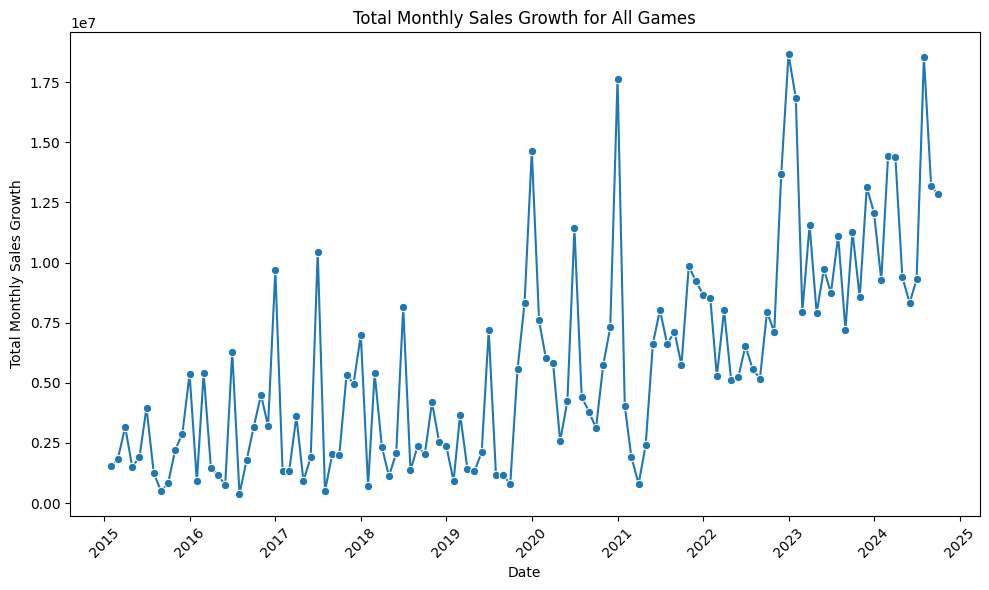

In [2]:
# 3A Action 每月銷售成長量
plot_total_sales_growth_trend('main_sales_growth_3A_Action.csv')

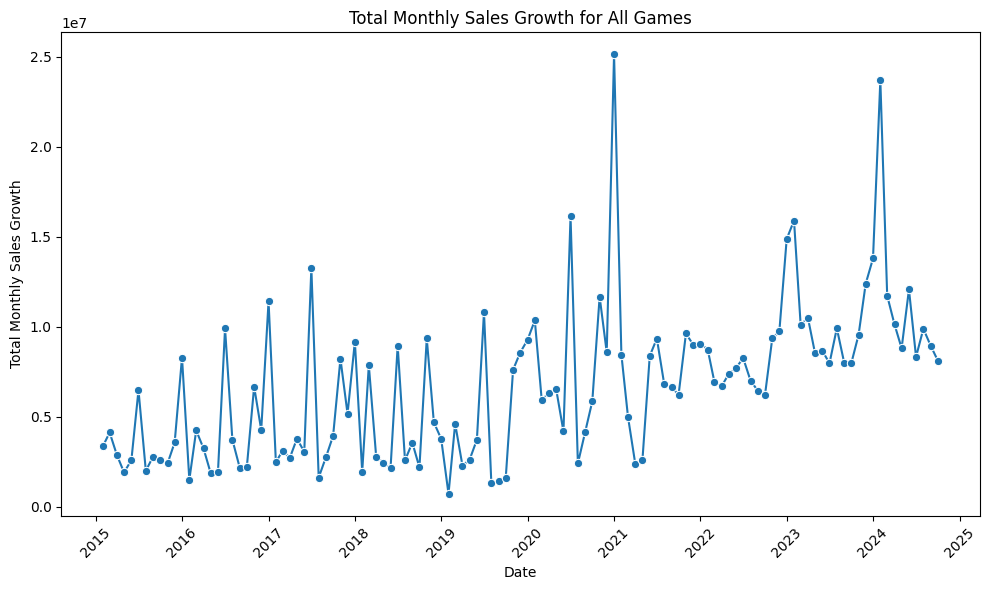

In [3]:
# 2A Action 每月銷售成長量
plot_total_sales_growth_trend('main_sales_growth_2A_Action.csv')

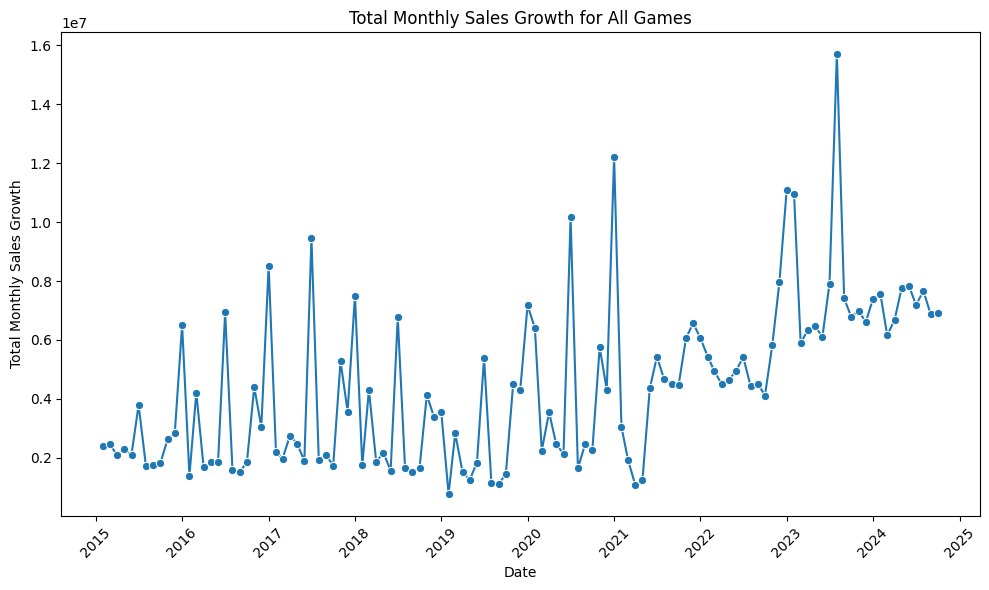

In [4]:
# indie Action 每月銷售成長量
plot_total_sales_growth_trend('main_sales_growth_indie_Action.csv')

### 3A 2A indie 每月銷售成長量，把圖放在一起比較

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sales_growth_comparison(aaa_csv, aa_csv, indie_csv):
    """
    繪製 3A、2A、indie 類別遊戲的銷售成長趨勢比較圖。
    
    參數：
    aaa_csv : str
        3A 類遊戲的 CSV 檔案。
    aa_csv : str
        2A 類遊戲的 CSV 檔案。
    indie_csv : str
        indie 類遊戲的 CSV 檔案。
    """
    # 讀取三個 CSV 文件
    df_3A = pd.read_csv(f"../../../data/processed/{aaa_csv}")
    df_2A = pd.read_csv(f"../../../data/processed/{aa_csv}")
    df_indie = pd.read_csv(f"../../../data/processed/{indie_csv}")

    # 確保 'year' 和 'month' 是整數，並創建時間序列
    for df in [df_3A, df_2A, df_indie]:
        df['year'] = df['year'].astype(int)
        df['month'] = df['month'].astype(int)
        df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

    # 添加一個 'category' 列來標記每個分類
    df_3A['category'] = '3A'
    df_2A['category'] = '2A'
    df_indie['category'] = 'Indie'

    # 合併三個 DataFrame
    df_combined = pd.concat([df_3A, df_2A, df_indie])

    # 過濾日期，排除 2015 年 1 月之前的資料
    df_combined = df_combined[df_combined['date'] > '2015-01-01']
    
    # 按日期和類別進行分組，計算每個類別的月度總銷售成長
    df_grouped = df_combined.groupby(['date', 'category'])['monthlySalesGrowth'].sum().reset_index()

    # 繪製銷售成長趨勢比較圖
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df_grouped, x='date', y='monthlySalesGrowth', hue='category', marker='o')

    # 設置標題和標籤
    plt.title('Monthly Sales Growth Comparison: 3A, 2A, Indie Games')
    plt.xlabel('Date')
    plt.ylabel('Total Monthly Sales Growth')

    # 顯示圖表
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(title='Category')
    plt.show()



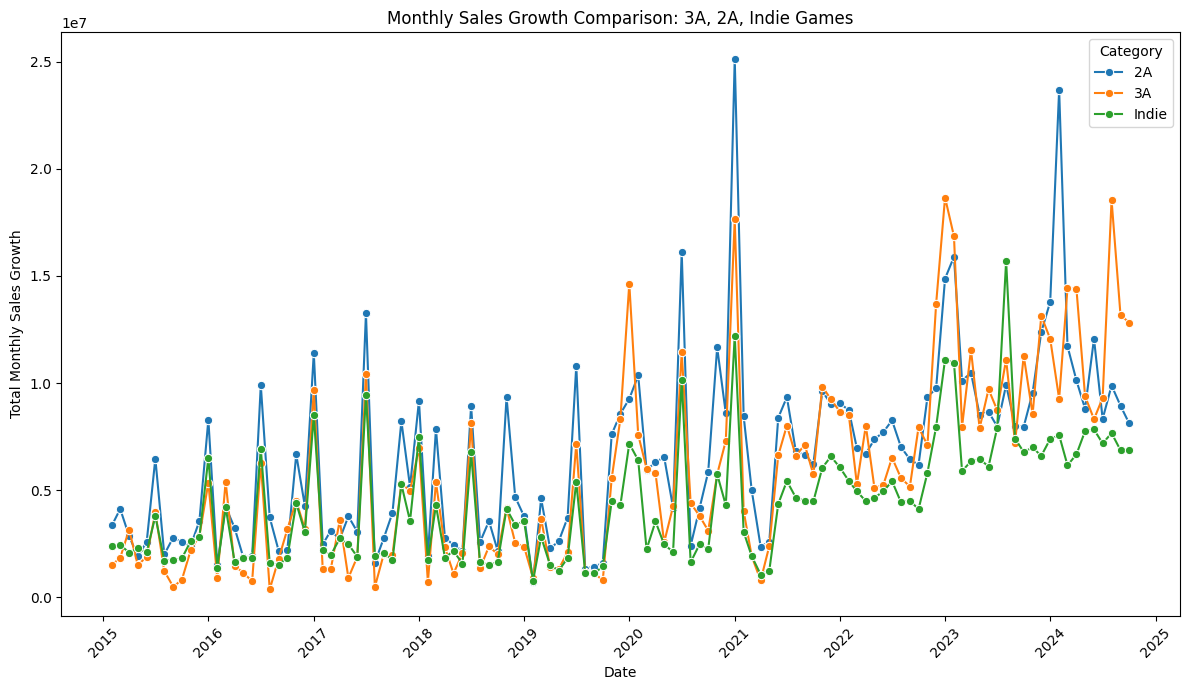

In [6]:
# 3A 2A indie Action遊戲(有篩掉免費遊戲) 每月銷售比較
plot_sales_growth_comparison('main_sales_growth_3A_Action.csv', 'main_sales_growth_2A_Action.csv', 'main_sales_growth_indie_Action.csv')